#1. Active Learning with Gaussian Process



In [0]:
## Active regression with ActiveLearner using Gaussian process 
!pip install modAL
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner

In [0]:
%matplotlib inline

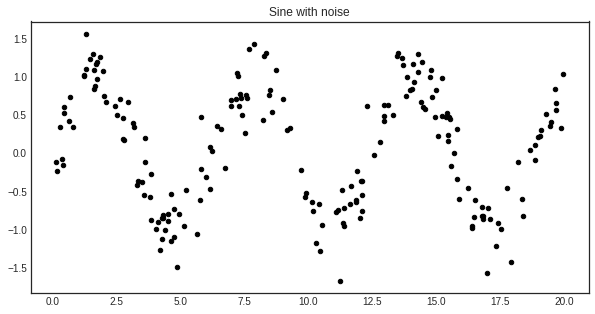

In [0]:
X = np.random.choice(np.linspace(0,20,10000),size=200,replace=False).reshape(-1,1)
y = np.sin(X) + np.random.normal(scale=0.3, size=X.shape)

with plt.style.context('seaborn-white'):
  plt.figure(figsize = (10,5))
  plt.scatter(X, y, c= 'k', s = 20)
  plt.title("Sine with noise")
  plt.show()

In [0]:
# Setting the query strategy to gaussian process regression
# This takes in an estimator and a bunch of data and turn it into an instance 
# estimator / classifier here is gaussian process regression 

def GP_regression_std(regressor, X):
    # measuring the utility of each instance in the pool 
    _, std = regressor.predict(X, return_std=True)

    # selecting the indices of the instances to be queried 
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

In [0]:
n_initial = 5
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_training, y_training = X[initial_idx], y[initial_idx]

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)

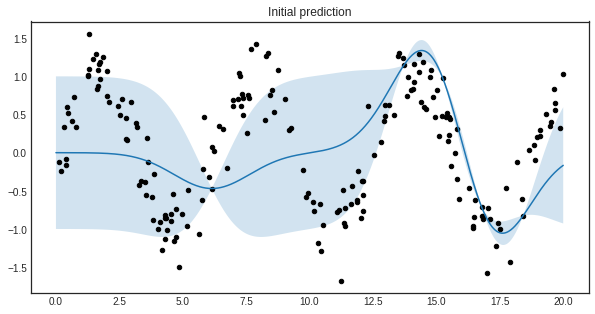

In [0]:
X_grid = np.linspace(0, 20, 1000)
y_pred, y_std = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.plot(X_grid, y_pred)
    plt.fill_between(X_grid, y_pred - y_std, y_pred + y_std, alpha=0.2) 
    # The blue band enveloping the regressor represents the standard deviation 
    # of the Gaussian process at the given point.
    plt.scatter(X, y, c='k', s=20)
    plt.title('Initial prediction')
    plt.show()

# The initial regressor is not very accurate 

**Active Learning**

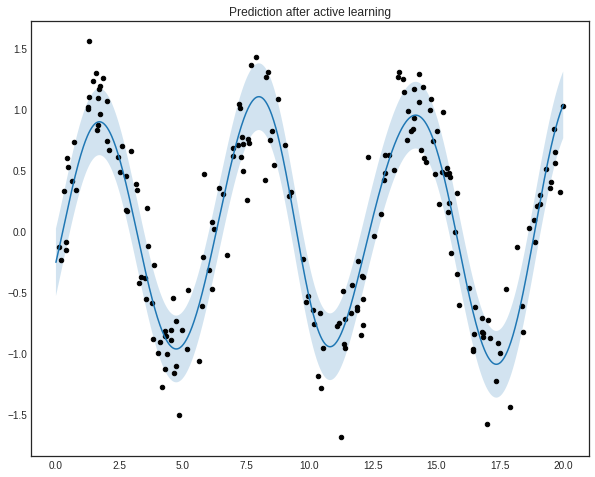

In [0]:
n_queries = 100

# query and then teach 
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X)
    regressor.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))

y_pred_final, y_std_final = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred_final, y_std_final = y_pred_final.ravel(), y_std_final.ravel()

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 8))
    plt.plot(X_grid, y_pred_final)
    plt.fill_between(X_grid, y_pred_final - y_std_final, y_pred_final + y_std_final, alpha=0.2)
    plt.scatter(X, y, c='k', s=20)
    plt.title('Prediction after active learning')
    plt.show()

# 2. Bayesian Optimizer Model on Regression Problem

From:
https://github.com/Ashkan66/CE888Assignment/blob/ce0146ce2387efda768d2efe904a1e61d93ae257/active%20learning%20on%20regression%20problem.ipynb

In [0]:
import numpy as np 
import pandas as pd

from sklearn import preprocessing
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge

from modAL.models import ActiveLearner
from modAL.acquisition import max_EI, max_PI, max_UCB
from modAL.models import BayesianOptimizer, CommitteeRegressor
from modAL.disagreement import max_std_sampling

In [0]:
# Example from the following repo:
dataset = np.loadtxt(r"https://raw.githubusercontent.com/Ashkan66/CE888Assignment/ce0146ce2387efda768d2efe904a1e61d93ae257/airfoil_self_noise.csv", delimiter=',', skiprows=1)
np.random.shuffle(dataset)

**Prepare dataset**

In [0]:
X = dataset[:,:-1]
# Create the Scaler object
scaler = preprocessing.StandardScaler()

# Fit your data on the scaler object
X = scaler.fit_transform(X)

y = dataset[:,-1].reshape(-1,1)
# y = scaler.fit_transform(y)

# the dataset is broken as follows: 
# 9% for training, 1% for 10-fold cross validation
# 2% for test set and 
# the rest is treated as the pool for active learning

n_train = round(0.09 * X.shape[0])
n_val = round(0.01 * X.shape[0])
n_test = round(0.02 * X.shape[0])

X_train = X[:n_train,:]
y_train = y[:n_train]

X_test = X[n_train : n_train + n_test, :]
y_test = y[n_train : n_train + n_test]

X_pool = X[n_train + n_test :, :]
y_pool = y[n_train + n_test :]

In [0]:
query_strats = [max_EI, max_PI, max_UCB]

for query_strat in query_strats:
    X_pool_temp = X_pool
    y_pool_temp = y_pool
    print('***')
    print(query_strat)
    
    kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

    # Initialize the active learner
    regressor = BayesianOptimizer(
        estimator=GaussianProcessRegressor(kernel=kernel),
        X_training=X_train, y_training=y_train,
        query_strategy=query_strat
    )

    y_pred = regressor.predict(X_test)
    print(mean_squared_error(y_test, y_pred))
    # Current MSE


    # active learning loop for 100 queries 
    n_queries = 100
    for idx in range(n_queries):
        query_idx, query_instance = regressor.query(X_pool_temp)
#         print(query_idx)
        query_instance = query_instance.reshape(1,-1)
        query_label = y[query_idx].reshape(1,-1)
        regressor.teach(query_instance, query_label)
        X_pool_temp = np.delete(X_pool_temp, query_idx, 0)
        y_pool_temp = np.delete(y_pool_temp, query_idx, 0)

    y_pred_final = regressor.predict(X_test)
    print(mean_squared_error(y_test, y_pred_final))
    # final MSE
  

NameError: ignored

**Committee regressor with max std sampling query strategy**


In [0]:
kernel1 = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
     + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
regressor1 = ActiveLearner(
        estimator=GaussianProcessRegressor(kernel=kernel1),
        X_training=X_train, y_training=y_train)
kernel2 = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2)) \
     + WhiteKernel(noise_level=2, noise_level_bounds=(1e-10, 1e+1))
regressor2 = ActiveLearner(
        estimator=GaussianProcessRegressor(kernel=kernel2),
        X_training=X_train, y_training=y_train)

learner_list = [regressor1, regressor2]

# initializing the Committee
committee = CommitteeRegressor(
    learner_list=learner_list,
    query_strategy=max_std_sampling
)

y_pred = committee.predict(X_test)
print(mean_squared_error(y_test, y_pred))

# active regression
n_queries = 100
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool)
    committee.teach(X_pool[query_idx], y_pool[query_idx].reshape(-1, 1))
    X_pool = np.delete(X_pool, query_idx, 0)
    y_pool = np.delete(y_pool, query_idx, 0)

y_pred_final = committee.predict(X_test)
print(mean_squared_error(y_test, y_pred_final))

123.50700210265839
91.97028343507245


## 3. AL + Keras Integration with sklearn wrapper for classification 

- MNIST dataset

In [2]:
!pip install modAL
import keras
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from modAL.models import ActiveLearner


In [0]:
# build function for the Keras' scikit-learn API
def create_keras_model():
    """
    This function compiles and returns a Keras model.
    Should be passed to KerasClassifier in the Keras scikit-learn API.
    """

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

    return model
  
# create the classifier
classifier = KerasClassifier(create_keras_model)

In [0]:
# read training data from mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(10000, 28, 28, 1).astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


In [13]:
n_initial = 1000
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
# print(initial_idx)

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

print(len(X_initial), len(X_train))

1000 60000


In [0]:
# generate the pool
# remove the initial data from the training dataset
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [15]:
print(len(X_pool))

59000


In [16]:
# initialize ActiveLearner
learner = ActiveLearner(
    estimator=classifier,
    X_training=X_initial, y_training=y_initial,
    verbose=1
)

# use 1000 X_initial and y_initial for training 
# use remaining 59000 for the pool in active learning ("unlabelled")


Epoch 1/1
1000/1000 [==============================] - 3s 3ms/step - loss: 1.6363 - accuracy: 0.4560


In [17]:
# the active learning loop
n_queries = 10
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool, n_instances=100, verbose=0)
    print(query_idx)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=True,
        verbose=1
    )
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)

[18533 28556  8202 15870 15269 17666 38381 31040 40247 44964 15299 30704
 36665 30346 15298 56716 30185  6392 17424 53609 10441 50195 53525 46237
  8742 34275 37006 29227 55313 17249 28822 56375 47140 42129 49863  4116
 28347 32759 47732  5319 39173  1034 10702 48051 42792  7498   262 23473
 37975 42389 35041 16853 26412 44138 15732  2002 14312 30742  3504 11514
  3298 51938  6868 24172  5600 57621  9099 43441 53066 41086 45120  5218
 40921 40677 12156 12332 20018 10463 12383 47979 37285 30149  3782  7597
 11015 18408 57539  9637 53283 23998 13679 32889 25609 34515 56553 10111
 18255 55579 53808 10493]
Epoch 1/1
100/100 [==============================] - 0s 4ms/step - loss: 2.1055 - accuracy: 0.3300
[36440 22818  7521 53862 41285 22501 46704 55330 50768 17341 17327 15720
 26878 22399 13379 26106 38373 52974 55492 20706 25994 30333  4404 19124
 56402 27067 56396 39219 41137 32665 44861 30907 46403 47298 35389 34911
  4811 13143 32695 22089 19359 42092 30997 31004 13088 32148 52806 56305

In [18]:
# the final accuracy score
print(learner.score(X_test, y_test, verbose=1))

10000/10000 [==============================] - 6s 627us/step
0.11349999904632568


In [38]:
len(X_test)

10000

In [39]:
# 70000 total
# 1000 initial
# 59000 pool AL
# 10000 test 
print(1000/70000, 59000/70000, 10000/70000)

0.014285714285714285 0.8428571428571429 0.14285714285714285


##4. AL + Keras Integration with sklearn wrapper for regression
- https://www.tensorflow.org/tutorials/keras/regression
- https://github.com/modAL-python/modAL/blob/master/examples/keras_integration.py

In [19]:
# Use seaborn for pairplot
!pip install -q seaborn
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [20]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

32768/30286 [================================] - 0s 2us/step


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [0]:
dataset.isna().sum()
dataset = dataset.dropna()

In [24]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
393,27.0,4,140.0,86.0,2790.0,15.6,82
394,44.0,4,97.0,52.0,2130.0,24.6,82
395,32.0,4,135.0,84.0,2295.0,11.6,82
396,28.0,4,120.0,79.0,2625.0,18.6,82
397,31.0,4,119.0,82.0,2720.0,19.4,82


In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

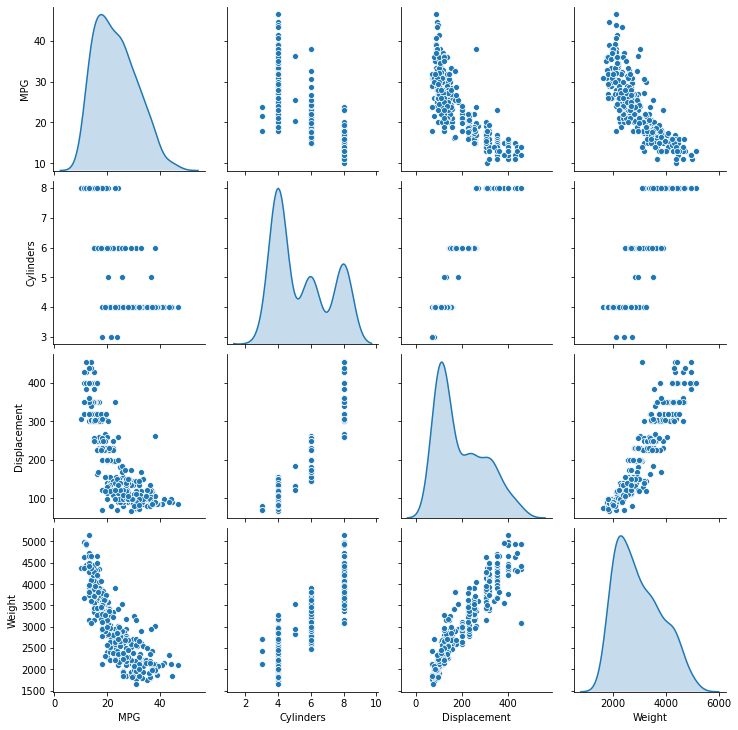

In [26]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


In [27]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


In [45]:
# 2, 78, 20

len(normed_train_data), len(normed_test_data), len(dataset)

(314, 78, 392)

initial, pool, test
- 14, 300, 78

In [0]:
# data further processing split train to initial and pooling
X_initial = normed_train_data[:14]
y_initial = train_labels[:14]
X_pool = normed_train_data[14:]
y_pool = train_labels[14:]
X_test = test_dataset
y_test = test_labels

In [60]:
def build_keras_regressor_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_keras_regressor_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.wrappers.scikit_learn import KerasRegressor
from modAL.models import ActiveLearner


In [0]:
# create the regressor from the function
regressor = KerasRegressor(build_keras_regressor_model)

In [64]:
# initialize ActiveLearner
learner = ActiveLearner(
    estimator=regressor,
    X_training=X_initial, y_training=y_initial,
    verbose=1
)

1/1 [==============================] - 0s 1ms/step - loss: 666.8597 - mae: 24.3765 - mse: 666.8597


In [66]:
# the active learning loop
n_queries = 50
for idx in range(n_queries):
    query_idx, query_instance = learner.query(X_pool, verbose=0)
    learner.teach(
        X=X_pool[query_idx], y=y_pool[query_idx], only_new=True,
        verbose=1
    )

# the final accuracy score
print(learner.score(X_test, y_test, verbose=1))

AttributeError: ignored